<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Naive-Bayes" data-toc-modified-id="Naive-Bayes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Naive Bayes</a></span><ul class="toc-item"><li><span><a href="#Experiment-Pipeline" data-toc-modified-id="Experiment-Pipeline-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Experiment Pipeline</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#Elastic-Net" data-toc-modified-id="Elastic-Net-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Elastic Net</a></span><ul class="toc-item"><li><span><a href="#Experiment-pipeline" data-toc-modified-id="Experiment-pipeline-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Experiment pipeline</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>RandomForest</a></span><ul class="toc-item"><li><span><a href="#Experiment-Pipeline" data-toc-modified-id="Experiment-Pipeline-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Experiment Pipeline</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Summary</a></span></li></ul></li></ul></div>

In this experiment we will build a simple pipeline using thew training set along with the handfull of binary features engineered during the project initiation stage to train classifiers using:

- Naive Bayes
- Elastic Net
- RandomForest
- Light Gradient Boosting
- Deep Neural Network

We will monitor `matthews_corrcoef` when training the classifiers and then document `classification_report` for both training and validation sets.

## Naive Bayes

### Experiment Pipeline

In [48]:
from sklearn.naive_bayes import BernoulliNB # Note that all features we will use here are binary
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef,make_scorer, balanced_accuracy_score
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle as pkl
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt


# load the configuration file
with open("config.json",'rb') as f:
    config = json.load(f)
feature_store_dir = config['feature_store_dir']    

# Load data sets, prepare x_train and y_train
analytical_data = pd.read_csv(feature_store_dir + 'analytical_data.csv')
train_knumber = pd.read_csv(feature_store_dir + 'train_KNUMBER.csv')
dummy_features = pd.read_csv(feature_store_dir + "features_dummy.csv")

x_train = pd.merge(train_knumber[['KNUMBER','DATASET']],
    analytical_data[['KNUMBER','COMPLEXITY']], how='left', on = "KNUMBER")
x_train = pd.merge(x_train,dummy_features, how = 'left', on='KNUMBER')
# Encode target labels:
# 0 = L, 1 = M, 2 = H
y_train = x_train[['KNUMBER','COMPLEXITY']].copy()
y_train.loc[:,'value'] = 0
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'M'] = 1
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'H'] = 2
y_train = y_train.loc[:,'value'].values

mcc = make_scorer(matthews_corrcoef)

def prepare_input(train_set):
    train_set = train_set.drop(['KNUMBER','DATASET', 'COMPLEXITY'],axis = 1)
    return train_set

clf_pipeline = Pipeline(steps=[
    ("prepare_input",FunctionTransformer(prepare_input)),
    ("add_poly_int", PolynomialFeatures()),
    ("feature_selection",SelectKBest(chi2)),
    ("clf",BernoulliNB())
])

param_grid = {
                "clf__alpha":np.linspace(1,1000,100),
                "clf__fit_prior":[True,False],
                "add_poly_int__degree":[1,2,3],
                "feature_selection__k":['all',10,20,30]
             }

clf_search = GridSearchCV(clf_pipeline,
                          param_grid = param_grid,
                          scoring = mcc,
                          cv = 5,
                          n_jobs=7,
                          verbose=2
                          )
clf_search.fit(X = x_train,y = y_train)

C:\Users\OZAN\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


C:\Users\OZAN\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.05671407 0.05386763        nan ... 0.08397096 0.09216756 0.033495  ]
  category=UserWarning


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prepare_input',
                                        FunctionTransformer(func=<function prepare_input at 0x0000017AD220E400>)),
                                       ('add_poly_int', PolynomialFeatures()),
                                       ('feature_selection',
                                        SelectKBest(score_func=<function chi2 at 0x0000017ACE4B4598>)),
                                       ('clf', BernoulliNB())]),
             n_jobs=7,
             param_grid={'add_poly_int__degree': [1, 2, 3],
                         'clf__alpha': array([   1.        ,...
        808.27272727,  818.36363636,  828.45454545,  838.54545455,
        848.63636364,  858.72727273,  868.81818182,  878.90909091,
        889.        ,  899.09090909,  909.18181818,  919.27272727,
        929.36363636,  939.45454545,  949.54545455,  959.63636364,
        969.72727273,  979.81818182,  989.90909091, 1000.        ]),
                

### Summary

Pipeline hyperparameters that performed the best:
{'add_poly_int__degree': 1, 'clf__alpha': 515.6363636363636, 'clf__fit_prior': False, 'feature_selection__k': 'all'}

Best cross-validated performance estimate (MCC): 0.1346

MCC estimate (training set):  0.1357

Balanced accuracy (training set): 0.3992

Classification report (training set):

              precision    recall  f1-score   support

           0       0.46      0.25      0.32      6668
           1       0.60      0.85      0.70     14307
           2       0.35      0.10      0.16      3951

    accuracy                           0.57     24926
   macro avg       0.47      0.40      0.39     24926
weighted avg       0.52      0.57      0.51     24926


Confusion matrix (training set):

[[ 1651  4828   189]
 [ 1624 12120   563]
 [  325  3220   406]]


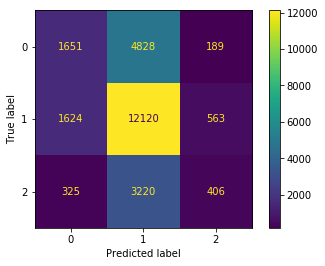

In [83]:
print('Pipeline hyperparameters that performed the best:')
print(clf_search.best_params_)
print("")
print("Best cross-validated performance estimate (MCC): "+ str(np.round(clf_search.best_score_,4)))
print("")
print("MCC estimate (training set): ", str(np.round(matthews_corrcoef(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print("Balanced accuracy (training set): "+ 
      str(np.round(balanced_accuracy_score(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print('Classification report (training set):')
print("")
print(classification_report(y_true = y_train, y_pred = clf_search.predict(x_train)))
print("")
print("Confusion matrix (training set):")
print("")
print(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di = ConfusionMatrixDisplay(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di.plot()
plt.show()
# Save the trained GridSearchCV object
with open("./models/experiment_1/naive_bayes.pkl","wb") as f:
    pkl.dump(clf_search,f)

## Elastic Net

### Experiment pipeline

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef,make_scorer, balanced_accuracy_score
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle as pkl
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime 

start_time = datetime.now()

# load the configuration file
with open("config.json",'rb') as f:
    config = json.load(f)
feature_store_dir = config['feature_store_dir']    

# Load data sets, prepare x_train and y_train
analytical_data = pd.read_csv(feature_store_dir + 'analytical_data.csv')
train_knumber = pd.read_csv(feature_store_dir + 'train_KNUMBER.csv')
dummy_features = pd.read_csv(feature_store_dir + "features_dummy.csv")

x_train = pd.merge(train_knumber[['KNUMBER','DATASET']],
    analytical_data[['KNUMBER','COMPLEXITY']], how='left', on = "KNUMBER")
x_train = pd.merge(x_train,dummy_features, how = 'left', on='KNUMBER')
# Encode target labels:
# 0 = L, 1 = M, 2 = H
y_train = x_train[['KNUMBER','COMPLEXITY']].copy()
y_train.loc[:,'value'] = 0
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'M'] = 1
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'H'] = 2
y_train = y_train.loc[:,'value'].values

mcc = make_scorer(matthews_corrcoef)

def prepare_input(train_set):
    train_set = train_set.drop(['KNUMBER','DATASET', 'COMPLEXITY'],axis = 1)
    return train_set

clf_pipeline = Pipeline(steps=[
    ("prepare_input",FunctionTransformer(prepare_input)),
    ("add_poly_int", PolynomialFeatures()),
    ("feature_selection",SelectKBest(chi2)),
    ("clf",LogisticRegression(penalty = "elasticnet", solver='saga'))
])

param_grid = {
                "clf__C":np.linspace(0,1,10).tolist() + np.linspace(1,100,10).tolist(),
                "clf__l1_ratio":np.linspace(0,1,10),
                "add_poly_int__degree":[2],
                "feature_selection__k":['all',10,20,30]
             }

clf_search = GridSearchCV(clf_pipeline,
                          param_grid = param_grid,
                          scoring = mcc,
                          cv = 5,
                          n_jobs=7,
                          verbose=7
                          )
clf_search.fit(X = x_train,y = y_train)

end_time = datetime.now()

print("Time elapsed: "+ str(round((end_time - start_time).seconds/60,4)) + " minutes.")

C:\Users\OZAN\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fitting 5 folds for each of 800 candidates, totalling 4000 fits


C:\Users\OZAN\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.0554313  0.0163434
 0.0539997  0.0554313  0.04663286 0.0163434  0.04520126 0.04663286
 0.04520126 0.0163434  0.04520126 0.04520126 0.04520126 0.0163434
 0.04520126 0.04520126 0.04520126 0.0163434  0.04520126 0.04520126
 0.04520126 0.0163434  0.04398132 0.04520126 0.04398132 0.0163434
 0.04398132 0.04398132 0.04327846 0.0163434  0.04327846 0.04327846
 0.03937162 0.0163434  0.03937162 0.03937162 0.03937162 0

Time elapsed: 16.4333 minutes.


### Summary

Pipeline hyperparameters that performed the best:
{'add_poly_int__degree': 2, 'clf__C': 23.0, 'clf__l1_ratio': 0.0, 'feature_selection__k': 20}

Best cross-validated performance estimate (MCC): 0.0583

MCC estimate (training set):  0.0927

Balanced accuracy (training set): 0.3562

Classification report (training set):

              precision    recall  f1-score   support

           0       0.50      0.11      0.18      6668
           1       0.58      0.96      0.73     14307
           2       0.00      0.00      0.00      3951

    accuracy                           0.58     24926
   macro avg       0.36      0.36      0.30     24926
weighted avg       0.47      0.58      0.47     24926


Confusion matrix (training set):

[[  742  5926     0]
 [  612 13695     0]
 [  138  3813     0]]


C:\Users\OZAN\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\OZAN\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\OZAN\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


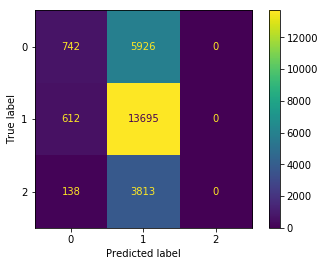

In [109]:
print('Pipeline hyperparameters that performed the best:')
print(clf_search.best_params_)
print("")
print("Best cross-validated performance estimate (MCC): "+ str(np.round(clf_search.best_score_,4)))
print("")
print("MCC estimate (training set): ", str(np.round(matthews_corrcoef(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print("Balanced accuracy (training set): "+ 
      str(np.round(balanced_accuracy_score(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print('Classification report (training set):')
print("")
print(classification_report(y_true = y_train, y_pred = clf_search.predict(x_train)))
print("")
print("Confusion matrix (training set):")
print("")
print(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di = ConfusionMatrixDisplay(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di.plot()
plt.show()
# Save the trained GridSearchCV object
with open("./models/experiment_1/elastic_net.pkl","wb") as f:
    pkl.dump(clf_search,f)

## RandomForest

### Experiment Pipeline

In [126]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef,make_scorer, balanced_accuracy_score
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle as pkl
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime 

start_time = datetime.now()

# load the configuration file
with open("config.json",'rb') as f:
    config = json.load(f)
feature_store_dir = config['feature_store_dir']    

# Load data sets, prepare x_train and y_train
analytical_data = pd.read_csv(feature_store_dir + 'analytical_data.csv')
train_knumber = pd.read_csv(feature_store_dir + 'train_KNUMBER.csv')
dummy_features = pd.read_csv(feature_store_dir + "features_dummy.csv")

x_train = pd.merge(train_knumber[['KNUMBER','DATASET']],
    analytical_data[['KNUMBER','COMPLEXITY']], how='left', on = "KNUMBER")
x_train = pd.merge(x_train,dummy_features, how = 'left', on='KNUMBER')
# Encode target labels:
# 0 = L, 1 = M, 2 = H
y_train = x_train[['KNUMBER','COMPLEXITY']].copy()
y_train.loc[:,'value'] = 0
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'M'] = 1
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'H'] = 2
y_train = y_train.loc[:,'value'].values

mcc = make_scorer(matthews_corrcoef)

def prepare_input(train_set):
    train_set = train_set.drop(['KNUMBER','DATASET', 'COMPLEXITY'],axis = 1)
    return train_set

clf_pipeline = Pipeline(steps=[
    ("prepare_input",FunctionTransformer(prepare_input)),
    ("add_poly_int", PolynomialFeatures()),
    ("feature_selection",SelectKBest(chi2)),
    ("clf",RandomForestClassifier(n_estimators = 300,random_state = 123))
])

param_grid = {
                "clf__min_samples_leaf":[100,250,500,750,1000],
                "clf__class_weight":['balanced','balanced_subsample'],
                "add_poly_int__degree":[1,2,3],
                "feature_selection__k":['all',10,20,30,50]
             }

clf_search = GridSearchCV(clf_pipeline,
                          param_grid = param_grid,
                          scoring = mcc,
                          cv = 5,
                          n_jobs=7,
                          verbose=7
                          )
clf_search.fit(X = x_train,y = y_train)

end_time = datetime.now()

print("Time elapsed: "+ str(round((end_time - start_time).seconds/60,4)) + " minutes.")

C:\Users\OZAN\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fitting 5 folds for each of 150 candidates, totalling 750 fits


C:\Users\OZAN\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.11536043 0.11486569        nan        nan        nan 0.08777692
 0.08777692        nan        nan        nan 0.07880594 0.07880594
        nan        nan        nan 0.07880594 0.07880594        nan
        nan        nan 0.07880594 0.07880594        nan        nan
        nan 0.11536043 0.11486569        nan        nan        nan
 0.08777692 0.08777692        nan        nan        nan 0.07880594
 0.07880594        nan        nan        nan 0.07880594 0.07880594
        nan        nan        nan 0.07880594 0.07880594        nan
        nan        nan 0.11536043 0.09147924 0.11486569 0.11536043
 0.11536043 0.08777692 0.07908109 0.08777692 0.08777692 0.08777692
 0.07880594 0.07880594 0.07880594 0.07880594 0.07880594 0.07880594
 0.07880594 0.07880594 0.07880594 0.07880594 0.07880594 0.07880594
 0.07880594 0.07880594 0.07880594 0.11536043 0.0914792

Time elapsed: 3.4833 minutes.


### Summary

Pipeline hyperparameters that performed the best:
{'add_poly_int__degree': 1, 'clf__class_weight': 'balanced', 'clf__min_samples_leaf': 100, 'feature_selection__k': 'all'}

Best cross-validated performance estimate (MCC): 0.1154

MCC estimate (training set):  0.1237

Balanced accuracy (training set): 0.4043

Classification report (training set):

              precision    recall  f1-score   support

           0       0.45      0.24      0.31      6668
           1       0.60      0.80      0.69     14307
           2       0.31      0.17      0.22      3951

    accuracy                           0.55     24926
   macro avg       0.45      0.40      0.41     24926
weighted avg       0.51      0.55      0.51     24926


Confusion matrix (training set):

[[ 1574  4796   298]
 [ 1593 11505  1209]
 [  323  2946   682]]


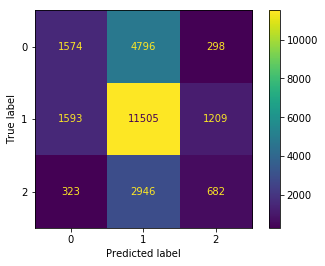

In [127]:
print('Pipeline hyperparameters that performed the best:')
print(clf_search.best_params_)
print("")
print("Best cross-validated performance estimate (MCC): "+ str(np.round(clf_search.best_score_,4)))
print("")
print("MCC estimate (training set): ", str(np.round(matthews_corrcoef(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print("Balanced accuracy (training set): "+ 
      str(np.round(balanced_accuracy_score(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print('Classification report (training set):')
print("")
print(classification_report(y_true = y_train, y_pred = clf_search.predict(x_train)))
print("")
print("Confusion matrix (training set):")
print("")
print(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di = ConfusionMatrixDisplay(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di.plot()
plt.show()
# Save the trained GridSearchCV object
with open("./models/experiment_1/randomForest.pkl","wb") as f:
    pkl.dump(clf_search,f)